In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
import re
positive_file = 'data/rt-polarity.pos'
negative_file = 'data/rt-polarity.neg'
data_root = 'data/stanfordSentimentTreebank/'
glove_pattern = 'data/glove.6B.<size>d.txt'
glove_size = 50

In [76]:
glove_dict = None
def get_glove(size = 50):
    global glove_dict
    if glove_dict is None or len(list(glove_dict.values())[0]) != size:
        file = re.sub('<size>', str(size), glove_pattern)
        glove = pd.read_csv(file, sep = " ", header = None, index_col = 0, quoting = 3)
        glove_dict = {key: val.values for key, val in glove.T.items()}
    return glove_dict

def preprocess_sentence(line):
    line = re.sub(r'[^\x00-\x7F]+', '', line.strip())
    return line.strip().lower()

def preprocess_for_labels(line):
    line = preprocess_sentence(line)
    line = re.sub('\W+', '', line.strip())
    return line
    
def get_labelset(file):
    with open(file, "rt", encoding="utf-8") as f:
        sentences = set([preprocess_for_labels(line) for line in f.readlines()])
    return sentences

In [64]:
positive_labelset = get_labelset(positive_file)
negative_labelset = get_labelset(negative_file)

In [65]:
data_split_dict = {}
data_split_map = {'1': 'train', '2': 'test', '3':'val'}
with open(data_root + 'datasetSplit.txt', 'r') as f:
    for line in f.readlines():
        [index, set_code] = line.strip().split(',')
        try:
            index = int(index)
        except:
            continue
        if set_code not in data_split_map:
            print(index, set_code)
        data_split_dict[index] = data_split_map.get(set_code, 'val')

In [66]:
def check_sentiment(sentence):
    s = preprocess_for_labels(sentence)
    for y, labelset in enumerate([negative_labelset, positive_labelset]):
        for entry in labelset:
            if s in labelset:
                return y
    return -1

sentences = {}
word2ind = {}
ttws = tf.keras.preprocessing.text.text_to_word_sequence
n_skipped = 0
idx = 0
with open(data_root + 'datasetSentences.txt') as data:
    lines = data.readlines()
    for line in lines:
        index = re.search('^\d+', line)
        if index is None:
            continue
        index = int(index.group())
        if index not in data_split_dict:
            print(index, line)
        entry = {'split_set': data_split_dict.get(index, 'val')}
        line = preprocess_sentence(line)
        line = re.sub(r'^\d+\s+', '', line)
        sentiment = check_sentiment(line)
        if sentiment >= 0:
            entry['y'] = sentiment
        else:
            n_skipped += 1
            continue
        sentences[line] = entry
        tokens = ttws(line)
        for token in tokens:
            if token not in word2ind:
                word2ind[token] = idx
                idx = idx + 1
            
print(n_skipped, ' skipped')
print(len(sentences), ' kept')

2775  skipped
9077  kept


In [67]:
data_splits = {title: {'x':[], 'y':[]} for title in ['train', 'test', 'val']}
for line, entry in sentences.items():
    which = entry['split_set']
    tokenized = [int(word2ind[token]) for token in ttws(line)]
    (data_splits[which]['x']).append(tokenized)
    (data_splits[which]['y']).append(int(entry['y']))

In [68]:
def get_dataset(label, sequence_len):
    vals = data_splits[label]
    x = [np.array(vx) for vx in vals['x']]
    x = tf.keras.preprocessing.sequence.pad_sequences(x, 
                                                      maxlen = sequence_len)
    y = np.array(vals['y'])
    return x, y

In [69]:
def get_embedding_matrix(glove_size):
    glove = get_glove(glove_size)
    glove_words = set(glove.keys())
    default_vector = np.mean(list(glove.values()), axis = 0)
    embedding_matrix = np.empty((len(word2ind), default_vector.shape[0]))
    excluded = []
    for word, position in word2ind.items():
        if word not in glove:
            excluded.append(word)
        embedding_matrix[position,:] = glove.get(word, default_vector)
    print(len(excluded), ' words from dataset not in glove')
    return embedding_matrix

# def gen_model(layer_type = tf.keras.layers.SimpleRNN, 
#               trainable = False, n_layers = 1, 
#               n_hidden_states = 8, lr = .01,
#               embedding_matrix = None, glove_size = 300):
#     if embedding_matrix is None:
#         embedding_matrix = get_embedding_matrix(glove_size)
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], 
#                                embedding_matrix.shape[1], 
#                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
#                                trainable = trainable)
#              )
#     for n in range(n_layers - 1):
#         model.add(layer_type(n_hidden_states, return_sequences = True))
#     model.add(layer_type(n_hidden_states))
#     model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
#     optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['BinaryAccuracy'])
#     return model

In [105]:
class RnnModel(tf.keras.Model):
    
    def __init__(self, 
                 hidden_states = None, 
                 embedding = 50, 
                 train_embeddings = False):
        super(RnnModel, self).__init__()
        self.init_layer_type()
        hidden_states = [8] if hidden_states is None else hidden_states
        embedding_matrix = get_embedding_matrix(glove_size)
        self.embedding = tf.keras.layers.Embedding(
            embedding_matrix.shape[0], 
            embedding_matrix.shape[1], 
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable = train_embeddings)
        self.final_rnn = self.layer_type(hidden_states.pop())
        self.hidden_layers = [self.layer_type(n, return_sequences = True) for n in hidden_states]
        self.logistic = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def init_layer_type(self):
        self.layer_type = tf.keras.layers.SimpleRNN
        
    def call(self, inputs, training = False):
        x = self.embedding(inputs)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.logistic(self.final_rnn(x))

class LstmModel(RnnModel):
    def init_layer_type(self):
        self.layer_type = tf.keras.layers.LSTM

class GruModel(RnnModel):
    def init_layer_type(self):
        self.layer_type = tf.keras.layers.GRU
            
def compile_model(model = RnnModel, lr = .01, model_args = {}):
    net = model(**model_args)
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['BinaryAccuracy'])
    return net

def run_model(model_type = RnnModel, epochs = 40, batch_size = 500, 
              sequence_len = 50, learning_rate = .01, model_args = {}):
    (xtrain, ytrain)= get_dataset('train', sequence_len)
    (xtest, ytest) = get_dataset('test', sequence_len)
    (xval, yval) = get_dataset('val', sequence_len)
    model = compile_model(model_type, learning_rate, model_args)
    train_history = model.fit(xtrain, ytrain, 
                              validation_data = (xval, yval),
                              batch_size = batch_size,
                              epochs = epochs)
    return train_history

In [106]:
vanilla_rnn_hist = run_model()
vanilla_hists = [vanilla_rnn_hist]

398  words from dataset not in glove
Train on 6530 samples, validate on 845 samples
Epoch 1/40
6530/6530 [==============================] - 1s 209us/sample - loss: 0.7418 - binary_accuracy: 0.5103 - val_loss: 0.6966 - val_binary_accuracy: 0.5361
Epoch 2/40
6530/6530 [==============================] - 0s 27us/sample - loss: 0.6788 - binary_accuracy: 0.5643 - val_loss: 0.6639 - val_binary_accuracy: 0.5834
Epoch 3/40
6530/6530 [==============================] - 0s 27us/sample - loss: 0.6616 - binary_accuracy: 0.6003 - val_loss: 0.6467 - val_binary_accuracy: 0.6331
Epoch 4/40
6530/6530 [==============================] - 0s 27us/sample - loss: 0.6477 - binary_accuracy: 0.6168 - val_loss: 0.6279 - val_binary_accuracy: 0.6568
Epoch 5/40
6530/6530 [==============================] - 0s 27us/sample - loss: 0.6322 - binary_accuracy: 0.6441 - val_loss: 0.6064 - val_binary_accuracy: 0.6828
Epoch 6/40
6530/6530 [==============================] - 0s 27us/sample - loss: 0.6260 - binary_accuracy: 0.645

In [107]:
vanilla_lstm_hist = run_model(LstmModel)
vanilla_hists.append(vanilla_lstm_hist)

398  words from dataset not in glove
Train on 6530 samples, validate on 845 samples
Epoch 1/40
6530/6530 [==============================] - 2s 283us/sample - loss: 0.6871 - binary_accuracy: 0.5447 - val_loss: 0.6655 - val_binary_accuracy: 0.6189
Epoch 2/40
6530/6530 [==============================] - 0s 60us/sample - loss: 0.6506 - binary_accuracy: 0.6282 - val_loss: 0.5912 - val_binary_accuracy: 0.7136
Epoch 3/40
6530/6530 [==============================] - 0s 59us/sample - loss: 0.5942 - binary_accuracy: 0.6856 - val_loss: 0.5333 - val_binary_accuracy: 0.7337
Epoch 4/40
6530/6530 [==============================] - 0s 60us/sample - loss: 0.5600 - binary_accuracy: 0.7136 - val_loss: 0.5255 - val_binary_accuracy: 0.7361
Epoch 5/40
6530/6530 [==============================] - 0s 59us/sample - loss: 0.5430 - binary_accuracy: 0.7291 - val_loss: 0.5348 - val_binary_accuracy: 0.7254
Epoch 6/40
6530/6530 [==============================] - 0s 60us/sample - loss: 0.5275 - binary_accuracy: 0.742

In [108]:
vanilla_gru_hist = run_model(GruModel)
vanilla_hists.append(vanilla_gru_hist)

398  words from dataset not in glove
Train on 6530 samples, validate on 845 samples
Epoch 1/40
6530/6530 [==============================] - 2s 279us/sample - loss: 0.6898 - binary_accuracy: 0.5499 - val_loss: 0.6506 - val_binary_accuracy: 0.6237
Epoch 2/40
6530/6530 [==============================] - 0s 52us/sample - loss: 0.6487 - binary_accuracy: 0.6179 - val_loss: 0.6180 - val_binary_accuracy: 0.6781
Epoch 3/40
6530/6530 [==============================] - 0s 52us/sample - loss: 0.6222 - binary_accuracy: 0.6567 - val_loss: 0.5707 - val_binary_accuracy: 0.7278
Epoch 4/40
6530/6530 [==============================] - 0s 52us/sample - loss: 0.5803 - binary_accuracy: 0.7080 - val_loss: 0.5271 - val_binary_accuracy: 0.7479
Epoch 5/40
6530/6530 [==============================] - 0s 55us/sample - loss: 0.5510 - binary_accuracy: 0.7217 - val_loss: 0.5044 - val_binary_accuracy: 0.7669
Epoch 6/40
6530/6530 [==============================] - 0s 54us/sample - loss: 0.5311 - binary_accuracy: 0.739

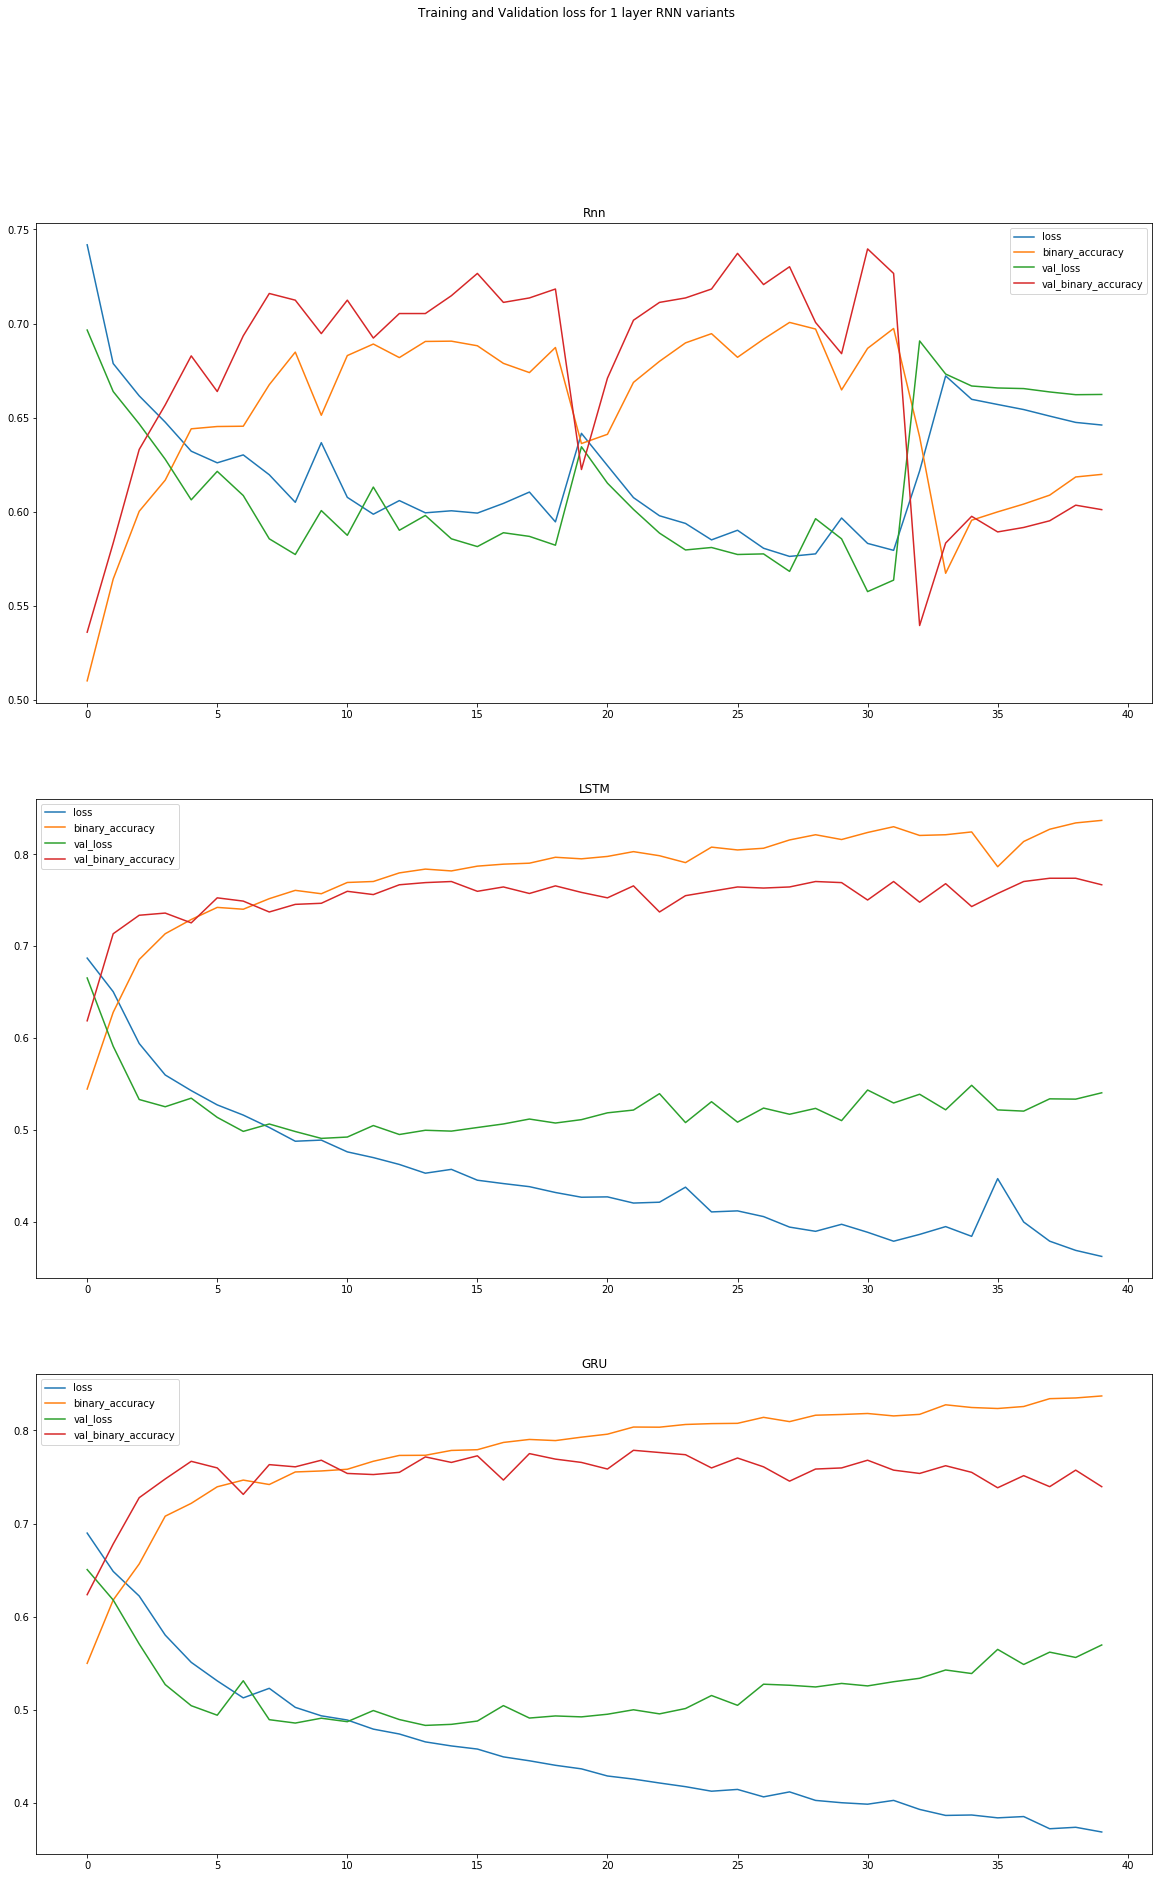

In [109]:
def plot_history(histories, title = None, sub_titles = None, width = 2):
    histories = [h.history for h in histories]
    n_plots = len(histories)
    options = {'figsize': [20,30]}
    fig, ax = plt.subplots(n_plots, **options)
    if title is not None:
        fig.suptitle(title)
    for i in range(n_plots):
        history = histories[i]
        for key, vals in history.items():
            ax[i].plot(range(len(vals)), vals, label=key)
            if sub_titles is not None:
                ax[i].set_title(sub_titles[i])
        if len(history.keys()) > 1:
            ax[i].legend()
plot_history(vanilla_hists,title = 'Training and Validation loss for 1 layer RNN variants', sub_titles = ['Rnn','LSTM','GRU'])